# Stochastic AVO Modelling

----------------------------------------------------------------------------

Application designed to do the following:
    (1) read user inputs for Mean and StdDev for each facies
    (2) create PDFs for each facies (N samples)
    (3) plot the PDFs -- sampled data and ellipses
    
Created by Damian Leslie, 2020  

----------------------------------------------------------------------------

###### import libraries

In [309]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns

from scipy.stats import norm, chi2, uniform, beta, gamma, lognorm
from statsmodels.graphics.plot_grids import scatter_ellipse
from matplotlib.patches import Ellipse

###### ask User for total number of facies (n_facies) and label names

In [310]:
facies_list = []   # creating an empty list

n_facies = int(input("Enter number of Facies to be modelled : "))   # number of Facies to be modelled

for i in range(0, n_facies):   # iterating over the number of Facies
    print("Assign name to Facies #",i+1)  
    ele = str(input("Facies: "))   # User input Facies name, i.e. shale, brine, oil, gas, etc
    facies_list.append(ele.capitalize()) # adding the element to the list and capitalise
print("Stochastic AVO Facies are: ",facies_list)

Enter number of Facies to be modelled :  4


Assign name to Facies # 1


Facies:  shale


Assign name to Facies # 2


Facies:  brine


Assign name to Facies # 3


Facies:  oil


Assign name to Facies # 4


Facies:  gas


Stochastic AVO Facies are:  ['Shale', 'Brine', 'Oil', 'Gas']


###### Create dictionary of df's to hold the Mean and Std Dev for VP, Vs and Rho
###### The facies' name is the dictionary key, the df are the values

In [311]:
elastic_inputs = ['Vp', 'Vs', 'Rho']  # list of elastic props
measure = ['Mean', 'StdDev']          # list of statistical measures
num_cols = len(facies_list) * len(elastic_inputs) * len(measure)  # get number of list columns
col_name = []    # create empty list for column names

while i <= num_cols:
    for facies in facies_list:
        for elas in elastic_inputs:
            for meas in measure:
                temp = facies+'_'+elas+'_'+meas   # set column names
                col_name.append(temp)   # append the name to the list
                i = i + 1

facies_array = np.zeros(shape=(1,len(col_name)))   # make array of zeros
facies_input = pd.DataFrame(facies_array, columns = col_name)   # convert to df with column names

i = 0 
for facies in facies_list:
    print('******************************************************')
    print('***********************', facies,'************************')
    for elas in elastic_inputs:
        print("For",elas,":")
        Mean, StdDev = [float(x) for x in (input("Enter Mean and Standard Deviation, separated by whitespace: ")).split()]
        facies_input.iloc[0,i] = Mean   # store Mean
        facies_input.iloc[0,i+1] = StdDev   # store Std Dev
        i = i + 2  # increment to next elastic property
 
n = int(input("Enter the number (integer) of realisations for the stochastic model: "))  # stochastic realisations
Near = int(input("Enter the Near Angle (integer, degrees) to be modelled: "))  # modelled Near stack
Far = int(input("Enter the Far Angle (integer, degrees) to be modelled: "))   # modelled Far stack
R_near = 'R_'+str(Near)   # set the angle to a string to become a df column name
R_far =  'R_'+str(Far)    # set the angle to a string to become a df column name

******************************************************
*********************** Shale ************************
For Vp :


Enter Mean and Standard Deviation, separated by whitespace:  2800 50


For Vs :


Enter Mean and Standard Deviation, separated by whitespace:  1500 50


For Rho :


Enter Mean and Standard Deviation, separated by whitespace:  2.7 0.05


******************************************************
*********************** Brine ************************
For Vp :


Enter Mean and Standard Deviation, separated by whitespace:  2600 50


For Vs :


Enter Mean and Standard Deviation, separated by whitespace:  1300 50


For Rho :


Enter Mean and Standard Deviation, separated by whitespace:  2.5 0.05


******************************************************
*********************** Oil ************************
For Vp :


Enter Mean and Standard Deviation, separated by whitespace:  2400 50


For Vs :


Enter Mean and Standard Deviation, separated by whitespace:  1200 50


For Rho :


Enter Mean and Standard Deviation, separated by whitespace:  2.3 0.05


******************************************************
*********************** Gas ************************
For Vp :


Enter Mean and Standard Deviation, separated by whitespace:  2000 50


For Vs :


Enter Mean and Standard Deviation, separated by whitespace:  1000 50


For Rho :


Enter Mean and Standard Deviation, separated by whitespace:  2.0 0.05
Enter the number (integer) of realisations for the stochastic model:  1000
Enter the Near Angle (integer, degrees) to be modelled:  10
Enter the Far Angle (integer, degrees) to be modelled:  30


###### User input is now finished -- start calculations 

###### Generate synthetic reflection coefficients for simple half-space model

    Layer 1 (Vp1, Vs1, Rho1)      <-- assumed as Shale
  ------------------------------
    Layer 2 (Vp2, Vs2, Rho2)      <-- can be Shale, Brine, Oil, Gas, etc

##### create a dictionary with names of temp df's to store the stochastic realisations

In [322]:
df_names_list = [x + '_PDFs' for x in list(facies_list)]   # create list with output df names
 
all_facies_PDFs = {}    # create dictionary with empty output df's
for name in df_names_list:
    all_facies_PDFs[name] = pd.DataFrame() 

##### set bounding shale PDFs outside the loop

In [323]:
Vp1 = norm(facies_input['Shale_Vp_Mean'], facies_input['Shale_Vp_StdDev']).rvs(n)   # Vp1 realisations
Vs1 = norm(facies_input['Shale_Vs_Mean'], facies_input['Shale_Vs_StdDev']).rvs(n)   # Vs1 realisations
Rho1 = norm(facies_input['Shale_Rho_Mean'], facies_input['Shale_Rho_StdDev']).rvs(n)   # Rho1 realisations

##### now loop over the target facies (including shale), first setting the facies PDF

In [324]:
for facies in facies_list:
    print('Modelling',n,'realisations for Facies =',facies)

    Vp2 = norm(facies_input[facies+'_Vp_Mean'], facies_input[facies+'_Vp_StdDev']).rvs(n)   # Vp2 realisations
    Vs2 = norm(facies_input[facies+'_Vs_Mean'], facies_input[facies+'_Vs_StdDev']).rvs(n)   # Vs2 realisations
    Rho2 = norm(facies_input[facies+'_Rho_Mean'], facies_input[facies+'_Rho_StdDev']).rvs(n)  # Rho2 realisations

    cols = ["Vp1","Vs1","Rho1","Vp2","Vs2","Rho2"]   # set thedf column names
        
    elastic_props = pd.DataFrame([Vp1, Vs1, Rho1, Vp2, Vs2, Rho2])  # concatenate the arrays as df
    elastic_props = elastic_props.T   # transpose
    elastic_props.columns = cols   # set df column names

    # calculate the variables for the 3-term AVO equation
    elastic_props['Vp'] = (elastic_props.Vp1 + elastic_props.Vp2)/2
    elastic_props['Vs'] = (elastic_props.Vs1 + elastic_props.Vs2)/2
    elastic_props['Rho'] = (elastic_props.Rho1 + elastic_props.Rho2)/2
    elastic_props['Vs_Vp_sqd'] = ( (elastic_props.Vs1/elastic_props.Vp1)**2 + (elastic_props.Vs2/elastic_props.Vp2)**2 ) / 2
    elastic_props['dVp'] = elastic_props.Vp2 - elastic_props.Vp1
    elastic_props['dVs'] = elastic_props.Vs2 - elastic_props.Vs1
    elastic_props['dRho'] = elastic_props.Rho2 - elastic_props.Rho1
    
    # calculate 3-term AVO coefficients
    elastic_props['A'] = 0.5*(elastic_props.dVp/elastic_props.Vp + elastic_props.dRho/elastic_props.Rho )
    elastic_props['B'] = elastic_props.dVp/(2*elastic_props.Vp) - 4*(elastic_props.Vs_Vp_sqd)*(elastic_props.dVs/elastic_props.Vs) -2*(elastic_props.Vs_Vp_sqd)*(elastic_props.dRho/elastic_props.Rho)
    elastic_props['C'] = 0.5*(elastic_props.dVp/elastic_props.Vp)
    
    # calculate the reflection coefficients for the given angles
    elastic_props[R_near] = elastic_props.A + elastic_props.B*(np.sin(Near*np.pi/180)**2) + elastic_props.C*(np.sin(Near*np.pi/180)**2)*(np.tan(Near*np.pi/180)**2)
    elastic_props[R_far] = elastic_props.A + elastic_props.B*(np.sin(Far*np.pi/180)**2) + elastic_props.C*(np.sin(Far*np.pi/180)**2)*(np.tan(Far*np.pi/180)**2)
    
    elastic_props_temp = elastic_props[[R_near, R_far]]      # extract the Near and Far reflection coefficients
    
    # write the 'elastic_props_temp' df to the corresponding df in the temp_df dictionary 
    df_name = [facies + '_PDFs']    

    for i in df_name:
        all_facies_PDFs[i] = elastic_props  # write the Near and Far rc's to a df within the facies_PDFs dictionary

Modelling 1000 realisations for Facies = Shale
Modelling 1000 realisations for Facies = Brine
Modelling 1000 realisations for Facies = Oil
Modelling 1000 realisations for Facies = Gas


## Functions for calculating PDF statistics and plotting

##### https://stats.stackexchange.com/questions/361017/proper-way-of-estimating-the-covariance-error-ellipse-in-2d

##### define function for sorted eigenvalues and eigenvectors

In [325]:
def eigsorted(cov):
    '''
    Eigenvalues and eigenvectors of the covariance matrix.
    '''
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

##### define function for confidence ellipse

In [326]:
def cov_ellipse2(points, cov, nstd):
    """
    Source: https://stackoverflow.com/a/39749274/1391441
    """

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[::-1, 0]))
    
    # Confidence level
    q = 2 * norm.cdf(nstd) - 1
    r2 = chi2.ppf(q, 2)
    
    width, height = 2 * np.sqrt(vals * r2)
    
    return width, height, theta

##### plotting data and ellipses -->  write as function???

In [327]:
nstd = 2  ## number of Std Dev for the ellipses 

PDF_concat = pd.DataFrame()  # create an empty df to hold the rfc point data - final size will be [n*n_facies, 4]
ellipse_concat = pd.DataFrame()  # make empty df for ellipse data: width, height , theta

for pdf in df_names_list:
    facies_label = pdf.split("_", 1)[0]   # make facies_label by stripping everything after &  inlcuding underscore
    
    temp_df = all_facies_PDFs[pdf]   # extract the df from the dictionary
    temp_rfc_df = temp_df[[R_near, R_far]]  # extract the R_near and R_far rfc columns
    ellipse_centre = temp_rfc_df[[R_near, R_far]].mean(axis=0)   # Means of R_near and R_far are the centre of the ellipses

    cov = np.cov(temp_rfc_df, rowvar=False)  # The 2x2 covariance matrix to base the ellipse on.
   
    width2, height2, theta2 = cov_ellipse2(temp_rfc_df, cov, nstd)  # calculate the ellipse parameters
    ellipse_temp = pd.DataFrame(np.array([width2, height2, theta2])).T #save to temp df
    ellipse_temp.columns = ("width2", "height2", "theta2")   # assign column names

    PDF_concat = pd.concat([PDF_concat, temp_rfc_df.assign(facies=facies_label)])  # vert. concatenate temp_rfc_df values with facie_label
    PDF_concat.reset_index(drop=True, inplace=True)  # stop index from resetting in each loop

    ellipse_concat = pd.concat([ellipse_concat, ellipse_temp.assign(facies=facies_label)])  # vert. concatenate ellipse parameters 
    ellipse_concat.reset_index(drop=True, inplace=True)  # stop index from resetting in each loop



##### define a function to map values of facies to a colour, then add a colour column to the df

In [328]:
def set_value(row_number, assigned_value): 
    return assigned_value[row_number] 
    
colour_dict = {'Shale' : 'black', 'Brine' : 'blue', 'Oil' : 'green', 'Gas' : 'red'}  # hard code the colours to match facies label -- in this case order is Shale, Brine, Oil, Gas 
PDF_concat['colour'] = PDF_concat['facies'].apply(set_value, args = (colour_dict, ))   # add colour column based on facies label

##### plotting function using the sns.jointGrid format
##### modified from https://stackoverflow.com/questions/35920885/how-to-overlay-a-seaborn-jointplot-with-a-marginal-distribution-histogram-fr

In [329]:
def multivariateGrid(col_x, col_y, col_f, col_k, df, k_is_color=True, scatter_alpha=0.25):
    def colored_scatter(x, y, c=None):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
            kwargs['alpha'] = scatter_alpha
            plt.scatter(*args, **kwargs)

        return scatter

    g = sns.JointGrid(x=col_x, y=col_y, xlim=(-0.5,0.5), ylim=(-0.5,0.5), data=df)
    sns.set_style("whitegrid")    
    color = None
    legends=df.facies.unique()  # extract the unique facies name for the plot legend
    
    for name, df_group in df.groupby(col_k):
        if k_is_color:
            color=name
            g.plot_joint(colored_scatter(df_group[col_x],df_group[col_y],color))

        sns.distplot(df_group[col_x].values, ax=g.ax_marg_x, hist=False, color=color)
        sns.distplot(df_group[col_y].values, ax=g.ax_marg_y, hist=False, color=color, vertical=True)
    # Do also global Hist:
    #sns.distplot(df[col_x].values, ax=g.ax_marg_x, color='grey')
    #sns.distplot(df[col_y].values.ravel(), ax=g.ax_marg_y, color='grey', vertical=True)
    plt.legend(legends)

##### now make the plot....

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


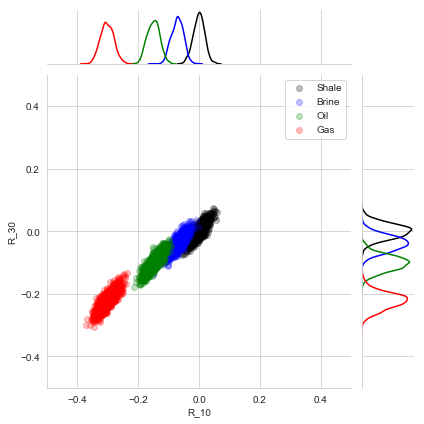

In [330]:
multivariateGrid('R_10', 'R_30', 'facies', 'colour', df=PDF_concat)

##### compare the input statistics and the PDF statistics as QC

##### plotting an ellipse based on PDF stats

In [331]:
#ax = plt.gca()
#plt.scatter(temp_rfc_df[R_near], temp_rfc_df[R_far], c='r', s=1, alpha=.5)
#ellipse2 = Ellipse(xy=ellipse_centre, width=width2, height=height2, angle=theta2,
#                       edgecolor='r', fc='None', lw=.8, zorder=4)
#ax.add_patch(ellipse2)